<a href="https://colab.research.google.com/github/Chung-0218/Toy_Project/blob/main/lstm_fdr_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U finance-datareader
# 패키지 설치 안되신 분은 위에 코드 주석해제하시고 패키지를 설치해주세요
# ref: https://github.com/huseinzol05/Stock-Prediction-Models
# and TGG amended some parameters and built data-pipeline which enables the code use FinanceDataReader data

Requirement already up-to-date: finance-datareader in /usr/local/lib/python3.7/dist-packages (0.9.31)


# 새 섹션

In [ ]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import FinanceDataReader as fdr

In [ ]:
def call_dataset(ticker = '005930', stt = '2015-01-01', end = '2021-03-30', history_points = 50):
    data = fdr.DataReader(ticker, stt, end)
    data = data.iloc[:,0:-1]
    print('data: ', data.shape)
    data = data.values # 값만 갖고온다
    data_normalizer = preprocessing.MinMaxScaler() # 데이터를 0~1 범위로 점철되게 하는 함수 call
    data_normalized = data_normalizer.fit_transform(data) # 데이터를 0~1 범위로 점철되게 함수 수행
    print('data_normalized: ', data_normalized.shape)
     # using the last {history_points} open close high low volume data points, predict the next open value
    ohlcv_histories_normalized = np.array([data_normalized[i:i + history_points].copy() for i in range(len(data_normalized) - history_points)]) # ohlcv를 가지고 오되, 관찰일수 만큼 누적해서 쌓는다. (열방향으로)
    print('ohlcv_histories_normalized: ', ohlcv_histories_normalized.shape)

    next_day_open_values_normalized = np.array([data_normalized[:, 0][i + history_points].copy() for i in range(len(data_normalized) - history_points)])
    next_day_open_values_normalized = np.expand_dims(next_day_open_values_normalized, -1) # 1XN 벡터 -> NX1 벡터로

    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1) # 1XN 벡터 -> NX1 벡터로

    y_normalizer = preprocessing.MinMaxScaler()
    y_normalizer.fit(next_day_open_values)

    # 인풋 X : 그 이전의 OHLCV (from T = -50 to T = -1)
    # 아웃풋 y : 예측하고자 하는 주가 T = 0

    def calc_ema(values, time_period):
        # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    technical_indicators = []
    for his in ohlcv_histories_normalized:
        # note since we are using his[3] we are taking the SMA of the closing price
        # print('his: ', his)
        # print('his[:, 3]: ', his[:, 3])
        sma = np.mean(his[:, 3]) # 각 데이터포인트별 Close Price 평균
        macd = calc_ema(his, 12) - calc_ema(his, 26) # 12일 EMA - 26일 EMA
        technical_indicators.append(np.array([sma]))
        # technical_indicators.append(np.array([sma,macd,]))

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalized = tech_ind_scaler.fit_transform(technical_indicators)

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalized = tech_ind_scaler.fit_transform(technical_indicators)

    assert ohlcv_histories_normalized.shape[0] == next_day_open_values_normalized.shape[0] == technical_indicators_normalized.shape[0]

    print('ohlcv_histories_normalized.shape[0]: ', ohlcv_histories_normalized.shape[0])

    return ohlcv_histories_normalized, technical_indicators_normalized, next_day_open_values_normalized, next_day_open_values, y_normalizer

In [ ]:
history_points = 50
ticker = '000660' # sk hynix

import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers
import numpy as np
np.random.seed(4)
# from tensorflow import set_random_seed
import tensorflow
print(tensorflow.__version__)
tensorflow.random.set_seed(44)
# from util import csv_to_dataset, history_points

# dataset

ohlcv_histories, _, next_day_open_values, unscaled_y, y_normaliser = call_dataset(ticker=ticker)

train_ratio = 0.7
n = int(ohlcv_histories.shape[0] * train_ratio)

ohlcv_train = ohlcv_histories[-n:-1]
y_train = next_day_open_values[-n:-1]

ohlcv_test = ohlcv_histories[:ohlcv_histories.shape[0]-n]
y_test = next_day_open_values[:ohlcv_histories.shape[0]-n]

unscaled_y_test = unscaled_y[:ohlcv_histories.shape[0]-n]

print('ohlcv_train.shape: ', ohlcv_train.shape)
print('ohlcv_test.shape: ',ohlcv_test.shape)

2.4.1
data:  (1518, 5)
data_normalized:  (1518, 5)
ohlcv_histories_normalized:  (1468, 50, 5)
ohlcv_histories_normalized.shape[0]:  1468
ohlcv_train.shape:  (1026, 50, 5)
ohlcv_test.shape:  (441, 50, 5)


In [ ]:
ohlcv_train 

array([[[0.13346856, 0.12917505, 0.13567404, 0.12953157, 0.0920164 ],
        [0.12494929, 0.122334  , 0.1231036 , 0.11649695, 0.24918289],
        [0.11764706, 0.11307847, 0.11443433, 0.11649695, 0.27400364],
        ...,
        [0.1643002 , 0.16418511, 0.16905072, 0.16089613, 0.18646085],
        [0.16592292, 0.16217304, 0.17598613, 0.16741344, 0.1188756 ],
        [0.16592292, 0.1637827 , 0.16991764, 0.16211813, 0.03128542]],

       [[0.12494929, 0.122334  , 0.1231036 , 0.11649695, 0.24918289],
        [0.11764706, 0.11307847, 0.11443433, 0.11649695, 0.27400364],
        [0.11156187, 0.11871227, 0.12006935, 0.12382892, 0.08420199],
        ...,
        [0.16592292, 0.16217304, 0.17598613, 0.16741344, 0.1188756 ],
        [0.16592292, 0.1637827 , 0.16991764, 0.16211813, 0.03128542],
        [0.16064909, 0.15855131, 0.17121803, 0.16211813, 0.00412072]],

       [[0.11764706, 0.11307847, 0.11443433, 0.11649695, 0.27400364],
        [0.11156187, 0.11871227, 0.12006935, 0.12382892, 0.0

In [ ]:
# model architecture
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
# evaluation

y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

from datetime import datetime
model.save(f'basic_model.h5')

Epoch 1/50
29/29 [==============================] - 3s 55ms/step - loss: 0.1133 - val_loss: 0.2064
Epoch 2/50
29/29 [==============================] - 1s 24ms/step - loss: 0.0184 - val_loss: 0.1498
Epoch 3/50
29/29 [==============================] - 1s 24ms/step - loss: 0.0140 - val_loss: 0.1294
Epoch 4/50
29/29 [==============================] - 1s 25ms/step - loss: 0.0125 - val_loss: 0.0993
Epoch 5/50
29/29 [==============================] - 1s 24ms/step - loss: 0.0092 - val_loss: 0.0702
Epoch 6/50
29/29 [==============================] - 1s 24ms/step - loss: 0.0051 - val_loss: 0.0223
Epoch 7/50
29/29 [==============================] - 1s 26ms/step - loss: 0.0030 - val_loss: 0.0292
Epoch 8/50
29/29 [==============================] - 1s 25ms/step - loss: 0.0022 - val_loss: 0.0309
Epoch 9/50
29/29 [==============================] - 1s 24ms/step - loss: 0.0018 - val_loss: 0.0264
Epoch 10/50
29/29 [==============================] - 1s 26ms/step - loss: 0.0020 - val_loss: 0.0243
Epoch 11/

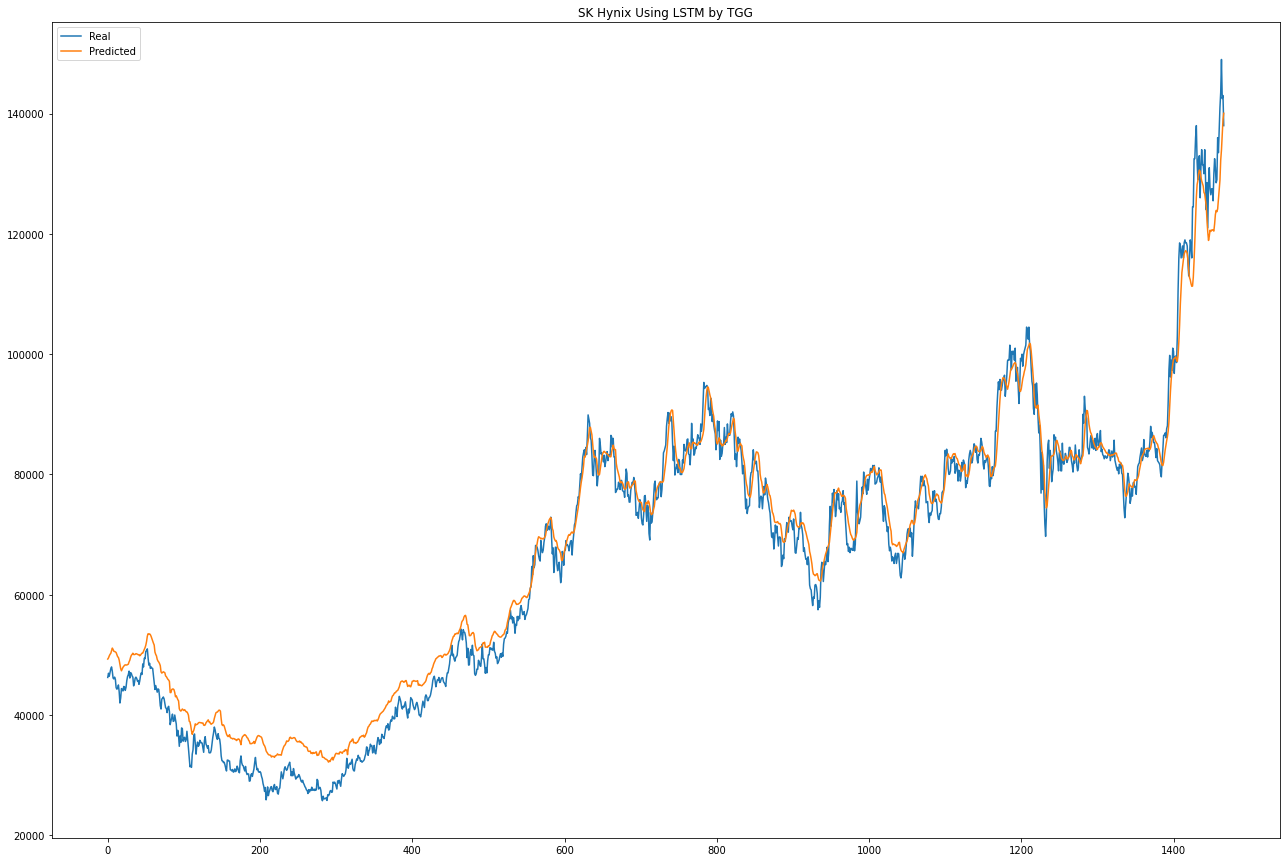

In [ ]:
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

# real = plt.plot(unscaled_y_test[start:end], label='real') 
# pred = plt.plot(y_test_predicted[start:end], label='predicted')

real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])
plt.title('SK Hynix Using LSTM by TGG')
plt.show()

In [ ]:
col_name = ['real', 'pred']
real, pred = pd.DataFrame(unscaled_y[start:end]), pd.DataFrame(y_predicted[start:end])
foo = pd.concat([real, pred], axis = 1)
foo.columns = col_name

In [ ]:
foo

,real,pred
0,46250,49305.968750
1,46950,49503.210938
2,46450,49837.453125
3,47100,50089.066406
4,47700,50260.589844
...,...,...
1462,143500,132243.750000
1463,149000,133956.328125
1464,142500,136571.203125
1465,143000,138999.921875


In [ ]:
foo.corr()

,real,pred
real,1.000000,0.995622
pred,0.995622,1.000000


In [ ]:
foo['real+1'] = foo['real'].shift(periods = 1)
foo[['real+1', 'pred']].corr()

,real+1,pred
real+1,1.000000,0.997414
pred,0.997414,1.000000
